<a href="https://colab.research.google.com/github/winengewe/diamond-price-resnet/blob/main/diamond_price_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# diamond-price-resnet

A production-ready Deep Learning pipeline for diamond valuation using a custom ResNet-MLP architecture and Log-Norm target engineering.

Using DEFAULT configuration.
--- 1. Loading and Cleaning Data ---
Original shape: (53940, 10)

Generating Correlation Matrix...


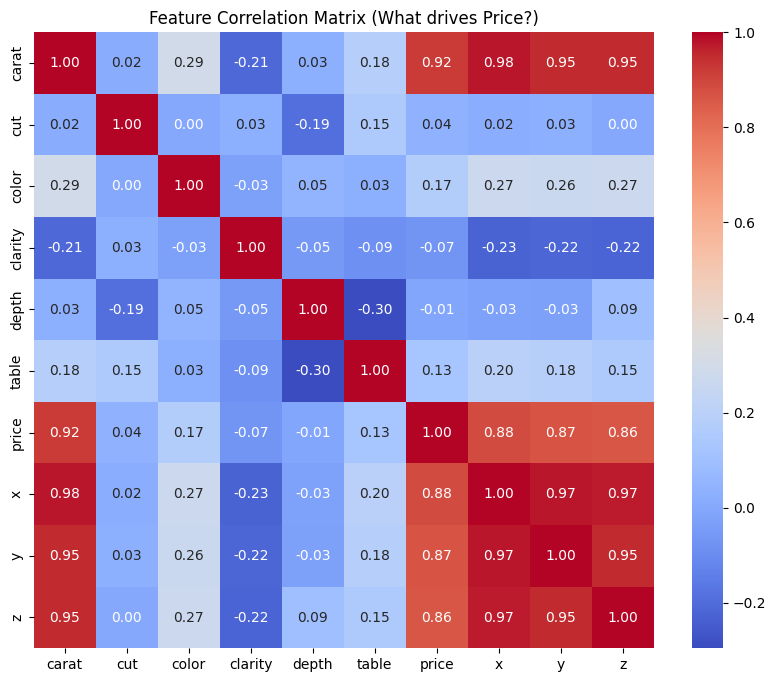

Note: 'Carat' and dimensions (x, y, z) have the highest correlation with Price.

Applying Log Transform to Target...
Fitting Preprocessor on Train Data...
Processed Train Shape X: (34521, 26)
Processed Val Shape X: (8631, 26)
Processed Test Shape X: (10788, 26)
Processed Train Shape y: (34521, 1)
Processed Val Shape y: (8631, 1)
Processed Test Shape y: (10788, 1)

--- 2. Training the Model ---


Model: "Diamond_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 192)       │      5,184 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 192)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192)       │        384 │ dropout_8[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 768)       │    148,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 192)       │    147,648 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 192)       │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 192)       │          0 │ dropout_8[0][0],  │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192)       │        384 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 768)       │    148,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 192)       │    147,648 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 192)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 192)       │          0 │ add_6[0][0],      │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192)       │        384 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 768)       │    148,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 192)       │    147,648 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 192)       │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 192)       │          0 │ add_7[0][0],      │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192)       │        384 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │        193 │ layer_normalizat

 Total params: 894,529 (3.41 MB)

 Trainable params: 894,529 (3.41 MB)

 Non-trainable params: 0 (0.00 B)


Average Train Price (Target): 7.79
Average Val Price (Target):   7.77

Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.7480 - mae: 0.3359 - val_loss: 0.0244 - val_mae: 0.1209
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0334 - mae: 0.1395 - val_loss: 0.0338 - val_mae: 0.1510
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0267 - mae: 0.1259 - val_loss: 0.0488 - val_mae: 0.1931
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0235 - mae: 0.1196 - val_loss: 0.0653 - val_mae: 0.2299
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0209 - mae: 0.1136 - val_loss: 0.0567 - val_mae: 0.2130
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0198 - mae: 0.1106 - val_loss: 0.0418 - val_mae: 0.1750
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0181 - mae: 0.1054 - val_loss: 0.0454 - val_mae: 0.1861
Epoch 8/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.0176 - m

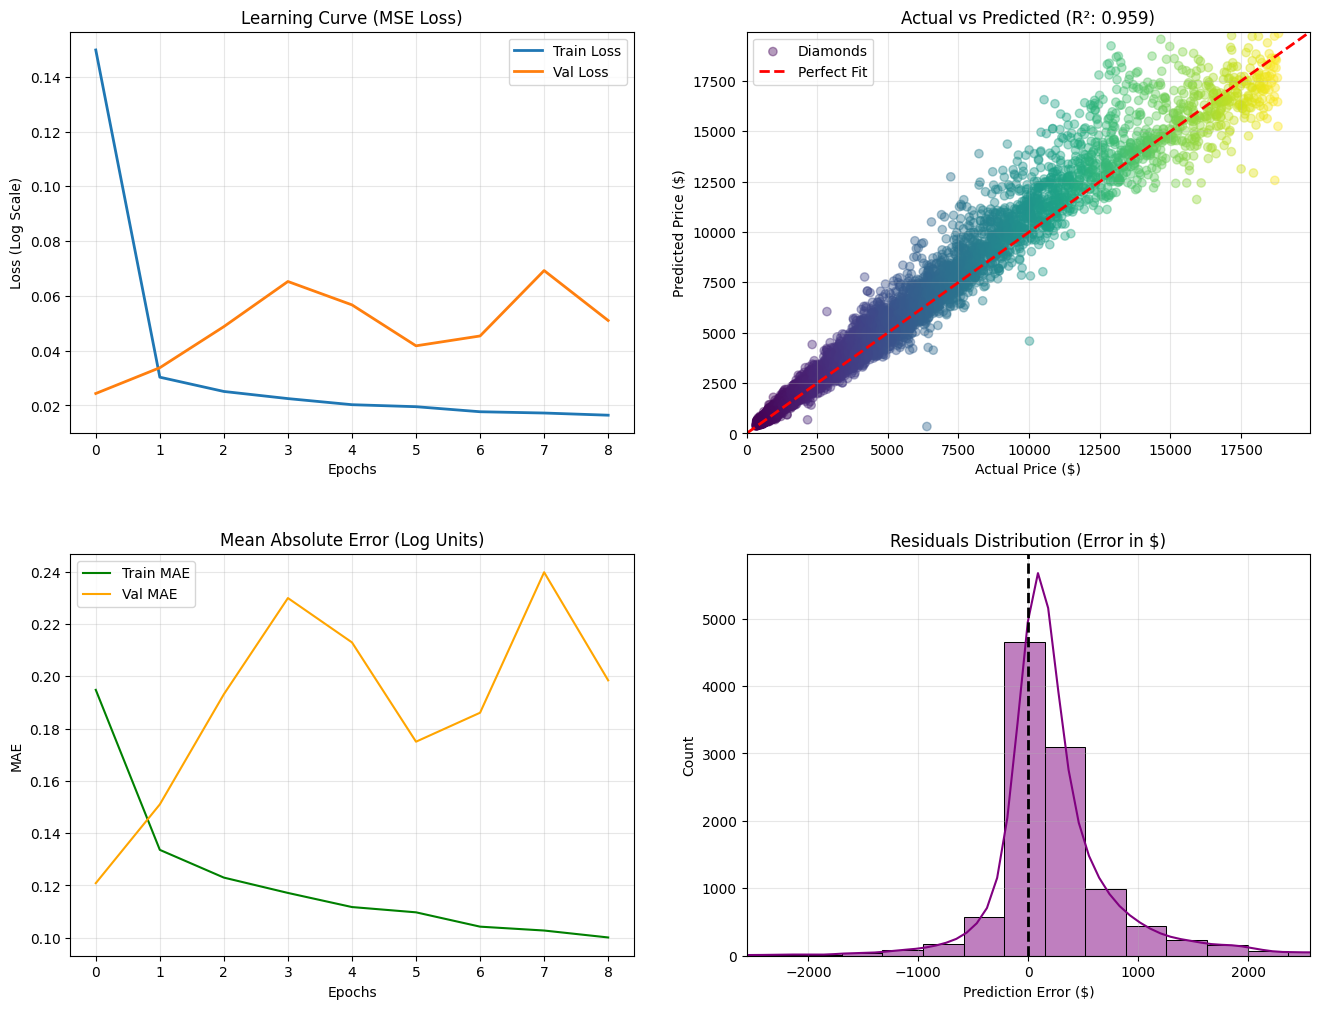


--- 4. Prediction Demo ---
Diamond Attributes: {'carat': 1.21, 'cut': 'Very Good', 'color': 'E', 'clarity': 'SI1', 'depth': 62.2, 'table': 60, 'x': 6.78, 'y': 6.76, 'z': 4.21}
Predicted Price: $7,892.66


In [3]:
# @title
# ==========================================
# 1. IMPORTS (Getting our tools)
# ==========================================
import pandas as pd             # For handling tables of data (like Excel)
import numpy as np              # For heavy math operations
import matplotlib.pyplot as plt # For drawing graphs
import seaborn as sns           # For loading the diamond dataset
import pickle                   # For saving our work to use later
import os                       # For talking to the operating system

# Machine Learning tools from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer # <--- NEW TOOL for Fix B
from sklearn.metrics import r2_score

# Deep Learning tools from TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, losses, metrics

# ==========================================
# CONFIGURATION
# ==========================================
TIMESERIES = 'No' # 'Yes' or 'No' for tabular regression
PROBLEM_TYPE = 'Regression' # 'Regression' or 'Classification'
OUTPUTS_NO = 1
# 1 for regression predicted value
# 2 for classification either 'fraud' or 'no fraud' / 'good' or 'bad'
# 10 for MNIST-1D

# --- MASTER SWITCH ---
# Set to False to use the fast settings below
USE_DEFAULTS = True

if USE_DEFAULTS:
    print("Using DEFAULT configuration.")
    EPOCHS = 50
    BATCH_SIZE = 32
    HIDDEN_LAYERS = 3
    Initial_LR = 0.001
    BASE_NEURONS = 64
else:
    print("Using CUSTOM (Fast Track) configuration.")
    EPOCHS = 5           # Reduced from 50 (Train for less time)
    BATCH_SIZE = 128     # Increased from 32 (Process more data at once)
    HIDDEN_LAYERS = 2    # Slightly smaller brain for speed
    Initial_LR = 0.001
    BASE_NEURONS = 64

# Settings to make sure get the same results every run / Ensure reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
keras.utils.set_random_seed(RANDOM_SEED)

# ==========================================
# 2. PREPARING THE DATA
# ==========================================
def load_and_process_data():
    print("--- 1. Loading and Cleaning Data ---")
    # Load the dataset (built into the seaborn library)
    df = sns.load_dataset('diamonds') # Pandas uses objects/strings and float64 by default
    print(f"Original shape: {df.shape}")

    # Remove any rows that have missing information (blank cells)
    # print("\nMissing values:\n", df.isnull().sum()) # Show the total of missing values for each column
    df = df.dropna()
    # print("\nAfter dropping rows with missing values:\n", df.isnull().sum())
    # print(f"\nCleaned shape: {df.shape}")

    # --- ENHANCEMENT 1: Correlation Matrix ---
    # We need to turn text columns into temporary numbers just for the heatmap
    print("\nGenerating Correlation Matrix...")
    df_analysis = df.copy()
    le = LabelEncoder()
    for col in ['cut', 'color', 'clarity']:
        df_analysis[col] = le.fit_transform(df_analysis[col])

    plt.figure(figsize=(10, 8))
    # Calculate how much every column correlates with every other column
    corr = df_analysis.corr()
    # Draw the heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Matrix (What drives Price?)")
    plt.show()
    print("Note: 'Carat' and dimensions (x, y, z) have the highest correlation with Price.\n")
    # ------------------------------------------

    # Separate the answers (Price) from the questions (Features)
    X = df.drop(columns=['price']) # The features (extra features: ['Class','Value'])
    y = df['price'] # The target (Price)

    # --- Concept: Train/Test Split ---
    # We hide 20% of the data (Test set) to quiz the model later.
    # We only train on the other 80%.
    # Instead of just Train/Test, split into Train/Validation/Test
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Split the full train into Train and Val
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # --- FIX A: Log Transformation for Price ---
    # Instead of StandardScaling the price, we use Logarithmic scaling.
    # np.log1p calculates log(1 + x) to handle zero values safely.
    # np.log1p(y) is usually all the scaling you need for financial data, and why adding StandardScaler on top of it is often redundant.
    print("Applying Log Transform to Target...")
    y_train = np.log1p(y_train)
    y_val = np.log1p(y_val)
    y_test = np.log1p(y_test)

    # --- FIX B: Column Transformer (The Pro Way) ---
    # We define a "processor" that treats numerical and categorical columns differently
    numerical_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
    categorical_cols = ['cut', 'color', 'clarity']

    # 1. Pipeline for Numbers: Just Scale them
    # 2. Pipeline for Categories: One Hot Encode them
    #    handle_unknown='ignore' ensures the code won't crash if a new weird category appears later.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
        ]
    )

    # Fit ONLY on Training data
    # Fit preprocessor ONLY on the smaller X_train
    print("Fitting Preprocessor on Train Data...")
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)   # Just transform
    X_test = preprocessor.transform(X_test) # Just transform

    # FINAL CONVERSION (float32 for training.)
    # NOW we convert everything to the format the Neural Network wants.

    # 1. Convert X to float32 (The preprocessor usually outputs float64)
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_test = X_test.astype('float32')

    # 2. Convert y to float32 and Reshape
    # .values turns the Pandas Series into a Numpy Array
    # .reshape(-1, 1) makes it a column vector (needed for Keras)
    y_train = y_train.astype('float32').values.reshape(-1, 1)
    y_val = y_val.astype('float32').values.reshape(-1, 1)
    y_test = y_test.astype('float32').values.reshape(-1, 1)

    print(f"Processed Train Shape X: {X_train.shape}")
    print(f"Processed Val Shape X: {X_val.shape}")
    print(f"Processed Test Shape X: {X_test.shape}")
    print(f"Processed Train Shape y: {y_train.shape}")
    print(f"Processed Val Shape y: {y_val.shape}")
    print(f"Processed Test Shape y: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, preprocessor

# Run the function
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = load_and_process_data()

# ========================================================
# 3. BUILDING THE BRAIN (Model Architecture: (ResNet-MLP))
# ========================================================
def build_neural_network(input_shape, hiddenlayers=3, base_neurons=64, outputs_no=1, problem_type='Regression'):
    # This is the entry door for data
    inputs = layers.Input(shape=input_shape)

    # Layer 1: A simple dense layer / Initial Linear Projection
    z = layers.Dense(base_neurons * hiddenlayers)(inputs) # for 'keras.layers.Add' same size with s (AI class)
    z = layers.Dropout(0.1)(z) # 'Dropout' randomly ignores 10% of neurons to prevent memorization

    # Layer 2: A complex block (ResNet style)
    # Residual Blocks with Inverted Bottleneck
    # (Similar to Transformer Feedforward Network (FFN): Expand -> Act -> Contract)
    for _ in range(hiddenlayers):
      shortcut = z
      z = layers.LayerNormalization()(z)  # Stabilizes the math / deep networks
      z = layers.Dense(4* base_neurons * hiddenlayers, activation='gelu')(z) # Expand to think about complex features (AI class)
      z = layers.Dense(base_neurons * hiddenlayers)(z) # Contract back down (AI class)
      z = layers.Dropout(0.1)(z) # Dropout on linear projection
      z = layers.Add()([shortcut, z])  # Add the original info back (Skip Connection)

    # Output Layer: One single number (The predicted price)
    z = layers.LayerNormalization()(z)

    # Output Logic
    if problem_type == 'Regression':
      activation = 'linear' # 'linear' for regression (default) ranges from $-\infty$ to $+\infty$
      # activation = 'gelu' # 'gelu' for regression (AI class) output -0.17 to Infinity
      loss_fn = losses.MeanSquaredError() # Penalize big errors heavily
      metric_list = [metrics.MeanAbsoluteError(name='mae')] # A human-readable error score
    elif problem_type == 'Classification':
      activation = 'sigmoid' if outputs_no == 1 else 'softmax'
      loss_fn = losses.SparseCategoricalCrossentropy() # (AI class)
      metric_list = [metrics.SparseCategoricalAccuracy()] # (AI class)
    else:
      raise ValueError(f"Unknown problem type: {problem_type}")

    outputs = layers.Dense(outputs_no, activation=activation)(z)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Diamond_ResNet")

    return model, loss_fn, metric_list

# ==========================================
# 4. TRAINING THE MODEL
# ==========================================
print("\n--- 2. Training the Model ---")

model, loss_fn, metric_list = build_neural_network(input_shape=(X_train.shape[1],),
hiddenlayers=HIDDEN_LAYERS, base_neurons=BASE_NEURONS,
outputs_no=OUTPUTS_NO, problem_type=PROBLEM_TYPE)

# Learning Rate Schedule (Cosine Decay)
# Smoothly lowers LR from Initial_LR to 0 over the course of training
total_steps = int(np.ceil(len(X_train) / BATCH_SIZE) * EPOCHS)
lr_schedule = optimizers.schedules.CosineDecay(initial_learning_rate=Initial_LR,decay_steps=total_steps)

# Compile tells the model how to measure its own errors
model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule),loss=loss_fn,metrics=metric_list)

model.summary()

# Safety Nets
# EarlyStopping: Stop training if the model stops improving (saves time)
# ModelCheckpoint: Always save the best version of the model, not just the last one
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint('best_diamond_model.keras', save_best_only=True, monitor='val_loss')
]


print(f"\nAverage Train Price (Target): {np.mean(y_train):.2f}")
print(f"Average Val Price (Target):   {np.mean(y_val):.2f}\n")

# --- EXPECTED OUTPUT ---
# Average Train Price (Target): 7.78  <-- (This is Log Scale)
# Average Val Price (Target):   7.79  <-- (This should also be Log Scale)

# --- IF YOU SEE THIS, IT IS BROKEN ---
# Average Train Price (Target): 7.78
# Average Val Price (Target):   3985.20 <-- (This is Dollar Scale!)

# The .fit() command is where the actual learning happens
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val), # Pass the explicit data instead of 'split'
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

# =======================================================
# 5. MODEL TESTING (EVALUATION & VISUALIZATION) & SAVING
# =======================================================
print("\n--- 3. Evaluation & Saving ---")

# 1. Generate Predictions
# The model predicts in "Log Scale", so we must convert back to Dollars using np.expm1
y_pred_log = model.predict(X_test, verbose=0)

# Inverse transform to get real dollars
y_test_dollars = np.expm1(y_test).ravel()    # Flatten to 1D array
y_pred_dollars = np.expm1(y_pred_log).ravel() # Flatten to 1D array

# Calculate Residuals (Error = Prediction - Actual)
residuals = y_pred_dollars - y_test_dollars

# 2. Calculate Metrics
mae_dollars = np.mean(np.abs(residuals))
mape = np.mean(np.abs(residuals / y_test_dollars)) * 100
r2 = r2_score(y_test_dollars, y_pred_dollars)
loss, mae_log = model.evaluate(X_test, y_test, verbose=0)

# --- Print Performance Report ---
print(f"\n{'='*30}")
print(f"     PERFORMANCE REPORT")
print(f"{'='*30}")
print(f"R² Score:        {r2:.4f} (Target: > 0.95)")
print(f"Test MAE ($):    ${mae_dollars:,.2f}")
print(f"Test MAE (Log):  {mae_log:.4f}")
print(f"Test MAPE:       {mape:.2f}%")
print(f"{'-'*30}")
print(f"Mean Residual:   ${np.mean(residuals):,.2f}")
print(f"Std of Residuals:${np.std(residuals):,.2f}")
print(f"{'='*30}\n")

# 3. Save Artifacts
# Save the preprocessor pipeline (Scalers/Encoders)
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("✅ Artifacts (preprocessor.pkl) saved.")

# Save the Keras model
model.save('final_diamond_model.keras')
print("✅ Final Model (final_diamond_model.keras) saved.")

# 4. Visualization Dashboard (2x2 Grid)
print("\nGenerating Dashboard...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3) # Add breathing room between rows

# --- PLOT 1: LOSS (MSE) ---
# Checks for Overfitting
ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Learning Curve (MSE Loss)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- PLOT 2: ACTUAL VS PREDICTED ---
# Visualizes Accuracy
ax2 = axes[0, 1]
# Use a color map to show density of points
scatter = ax2.scatter(y_test_dollars, y_pred_dollars, alpha=0.4, c=y_test_dollars, cmap='viridis', label='Diamonds')
# The "Perfect Prediction" Line
max_val = np.percentile(y_test_dollars, 99.5) * 1.1 # Cap at 99.5% to hide extreme outliers
ax2.plot([0, max_val], [0, max_val], color='red', linewidth=2, linestyle='--', label='Perfect Fit')
ax2.set_title(f'Actual vs Predicted (R²: {r2:.3f})')
ax2.set_xlabel('Actual Price ($)')
ax2.set_ylabel('Predicted Price ($)')
ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- PLOT 3: ABSOLUTE ERROR (MAE) ---
# Checks Training Stability
ax3 = axes[1, 0]
ax3.plot(history.history['mae'], label='Train MAE', color='green')
ax3.plot(history.history['val_mae'], label='Val MAE', color='orange')
ax3.set_title('Mean Absolute Error (Log Units)')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MAE')
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- PLOT 4: RESIDUALS DISTRIBUTION ---
# Checks for Bias (Are we consistently wrong?)
ax4 = axes[1, 1]
sns.histplot(residuals, kde=True, bins=50, color='purple', ax=ax4)
ax4.axvline(x=0, color='k', linestyle='--', linewidth=2)
ax4.set_title('Residuals Distribution (Error in $)')
ax4.set_xlabel('Prediction Error ($)')
# Limit x-axis to focus on the bulk of data (exclude extreme outliers)
limit_res = np.percentile(np.abs(residuals), 98)
ax4.set_xlim(-limit_res, limit_res)
ax4.grid(True, alpha=0.3)

plt.show()

# ==========================================
# 6. USING THE MODEL (Prediction)
# ==========================================
print("\n--- 4. Prediction Demo ---")

# Load artifacts once
loaded_model = keras.models.load_model('best_diamond_model.keras')
with open('preprocessor.pkl', 'rb') as f:
    loaded_preprocessor = pickle.load(f)

def predict_diamond_price(new_data_dict, model, preprocessor):
    """
    Accepts raw features, processes via ColumnTransformer,
    predicts Log-Price, and converts back to Dollars.
    """
    # 1. Convert the dictionary to a DataFrame Table
    input_df = pd.DataFrame([new_data_dict])

    # 2. Process using the pipeline (Scales numbers & Encodes text automatically)
    #    (This handles the OneHotEncoding alignment automatically!)
    input_processed = preprocessor.transform(input_df)

    # 3. Predict (Result is in Log Scale)
    prediction_log = model.predict(input_processed, verbose=0)

    # 4. Inverse Log (Convert back to Real Dollars)
    #    np.expm1 is the inverse of np.log1p
    prediction_dollars = np.expm1(prediction_log)

    return prediction_dollars[0][0]


# --- Demo ---
# Let's pretend we have a new diamond to sell

"""
sample_diamond = {
    'carat': 1.5,
    'cut': 'Ideal',
    'color': 'G',
    'clarity': 'VVS2',
    'depth': 61.5,
    'table': 55.0,
    'x': 7.0, 'y': 7.0, 'z': 4.3
}
"""

sample_diamond = { #18818
    'carat': 1.21,
    'cut': 'Very Good',
    'color': 'E',
    'clarity': 'SI1',
    'depth': 62.2,
    'table': 60,
    'x': 6.78, 'y': 6.76, 'z': 4.21
} # expected 7703

predicted_price = predict_diamond_price(sample_diamond, loaded_model, loaded_preprocessor)
print(f"Diamond Attributes: {sample_diamond}")
print(f"Predicted Price: ${predicted_price:,.2f}")